[array([10.24, 10.24, 10.24, ..., 10.24, 10.24, 10.24]), array([10.24, 10.24, 10.24, ..., 10.24, 10.24, 10.24]), array([10.24,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]), array([10.24, 10.24, 10.24, ..., 10.24, 10.24,  0.  ]), array([-40.96, -40.96, -40.96, ..., -40.96, -40.96, -40.96]), array([ 0.  , 10.24, 10.24, ..., 10.24, 10.24, 10.24]), array([ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  , 10.24]), array([10.24, 10.24, 10.24, ..., 10.24, 10.24, 10.24]), array([10.24, 10.24, 10.24, ..., 10.24, 10.24, 10.24])]


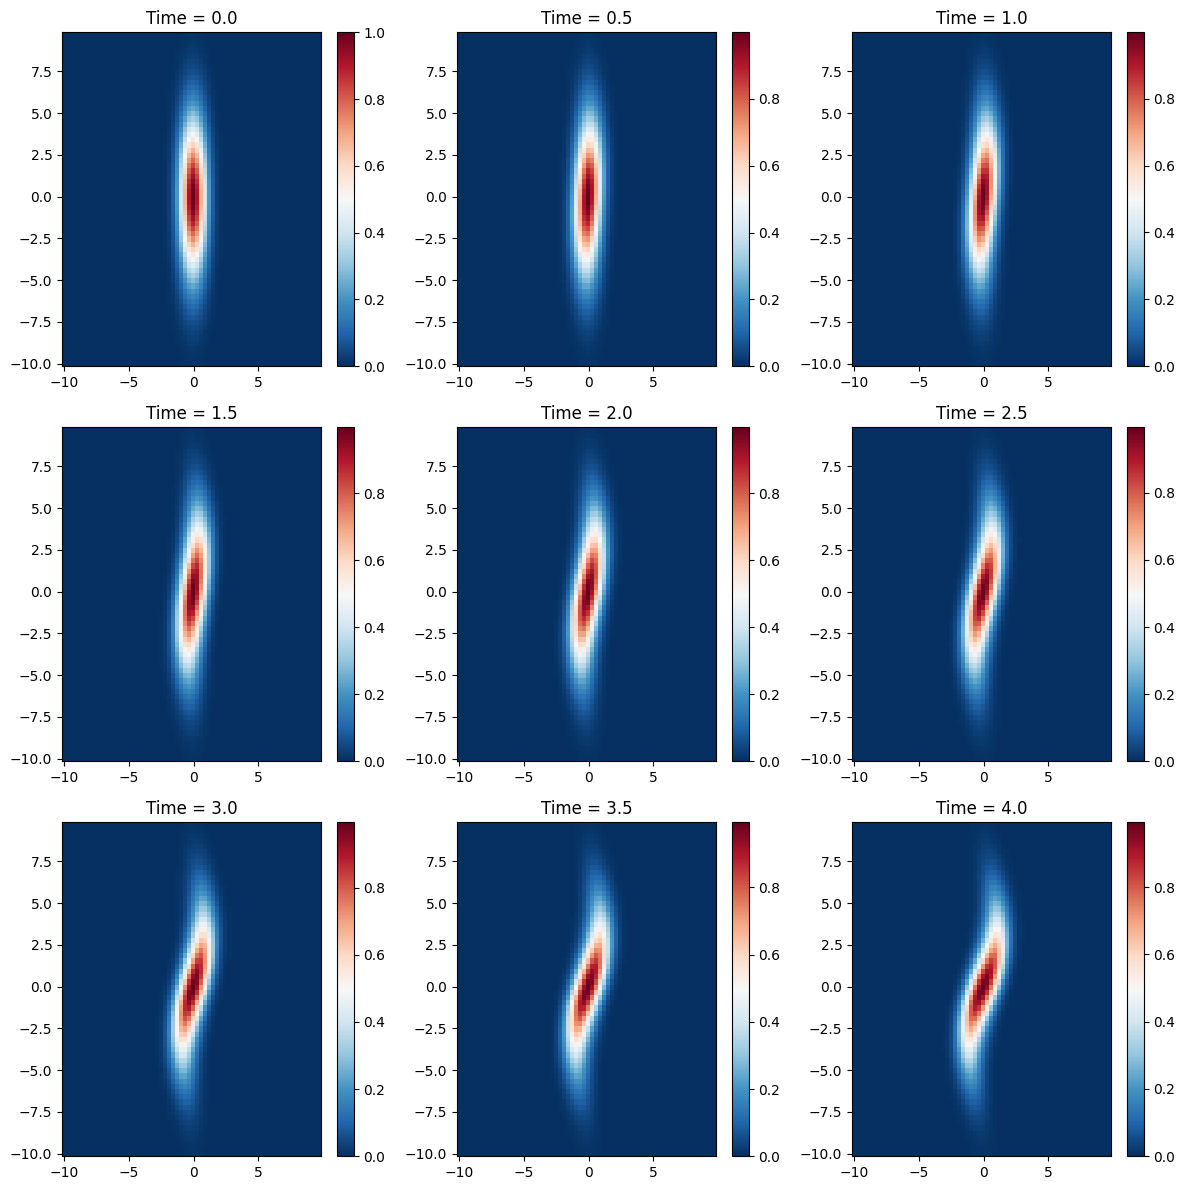

[[2.50656748e-46+0.j 3.59466667e-45+0.j 1.89127178e-44+0.j ...
  1.90568725e-42+0.j 4.81728605e-42+0.j 1.14686188e-41+0.j]
 [1.17762859e-43+0.j 6.53338260e-43+0.j 2.62118987e-42+0.j ...
  1.58626174e-40+0.j 3.55685364e-40+0.j 7.45764991e-40+0.j]
 [4.55107657e-41+0.j 1.93156349e-40+0.j 6.42961270e-40+0.j ...
  2.48833603e-38+0.j 5.07091554e-38+0.j 9.69808872e-38+0.j]
 ...
 [1.96785570e-38+0.j 1.23514556e-37+0.j 5.48585199e-37+0.j ...
  4.35724383e-35+0.j 1.02319708e-34+0.j 2.22945858e-34+0.j]
 [6.19028421e-41+0.j 5.33759294e-40+0.j 2.94632786e-39+0.j ...
  3.68518115e-37+0.j 9.45233976e-37+0.j 2.23446689e-36+0.j]
 [1.60178709e-43+0.j 2.00064727e-42+0.j 1.41437992e-41+0.j ...
  2.80608458e-39+0.j 7.96230326e-39+0.j 2.07445537e-38+0.j]]
[[ 2.50656748e-46+0.j -2.16477363e-36+0.j  1.33390876e-36+0.j ...
  -8.19491093e-26+0.j -7.30916709e-25+0.j  3.33437048e-24+0.j]
 [ 1.17762859e-43+0.j -2.25976671e-29+0.j  1.85550176e-29+0.j ...
  -2.10221761e-19+0.j -7.52172214e-19+0.j  1.63906992e-18+0.j

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from scipy.sparse import spdiags
from scipy.integrate import solve_ivp
from scipy.linalg import lu, solve_triangular

# Define parameters
tspan = np.arange(0, 4 + 0.5, 0.5)
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

# Define spatial domain and initial conditions
x2 = np.linspace(-Lx / 2, Lx / 2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly / 2, Ly / 2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
w = 1 * np.exp(-X**2 - Y**2 / 20) + 1j * np.zeros((nx, ny))
w2 = w.reshape(N)

# Define spectral k values
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx / 2), np.arange(-nx / 2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny / 2), np.arange(-ny / 2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

# Finite difference setup
m = 64  # N value in x and y directions
n = m * m  # total size of matrix

h = 0.3125  # Step size

e0 = np.zeros((n, 1))  # vector of zeros
e1 = np.ones((n, 1))   # vector of ones
e2 = np.copy(e1)    # copy the one vector
e4 = np.copy(e0)    # copy the zero vector

for j in range(1, m + 1):
    e2[m * j - 1] = 0
    e4[m * j - 1] = 1

# Shift to correct positions
e3 = np.zeros_like(e2)
e3[1:] = e2[:-1]
e3[0] = e2[-1]

e5 = np.zeros_like(e4)
e5[1:] = e4[:-1]
e5[0] = e4[-1]

# Place diagonal elements
diagonals_A = [e1.flatten()/h**2, e1.flatten() / h**2, e5.flatten() / h**2,
               e2.flatten() / h**2, -4 * e1.flatten() / h**2, e3.flatten() / h**2,
               e4.flatten() / h**2, e1.flatten() / h**2, e1.flatten() / h**2]
offsets_A = [-(n - m), -m, -m + 1, -1, 0, 1, m - 1, m, (n - m)]
diagonals_B = [e1.flatten() / (2 * h), -e1.flatten() / (2 * h), e1.flatten() / (2 * h), -e1.flatten() / (2 * h)]
offsets_B = [-(n - m), -m, m, (n - m)]
diagonals_C = [e5.flatten() / (2 * h), -e2.flatten() / (2 * h), e3.flatten() / (2 * h), -e4.flatten() / (2 * h)]
offsets_C = [-m + 1, -1, 1, m - 1]

print(diagonals_A)

A = spdiags(diagonals_A, offsets_A, n, n).toarray()
B = spdiags(diagonals_B, offsets_B, n, n).toarray()
C = spdiags(diagonals_C, offsets_C, n, n).toarray()
A[0,0] = 2/h**2

# Define the PDE system
def spc_rhs(t, wt2, nx, ny, N, KX, KY, K, nu):
    w = wt2.reshape((nx, ny))
    wt = fft2(w)
    psit = -wt / K
    psi = np.real(ifft2(psit)).reshape(N)
    rhs = nu * (A @ wt2) - (B @ psi) * (C @ wt2) + (B @ wt2) * (C @ psi)
    return rhs

# Solve the system
wsol = solve_ivp(spc_rhs, [0, 4], w2, t_eval=tspan, args=(nx, ny, N, KX, KY, K, nu), method='RK45')
A1 = wsol.y


# Visualization
plt.figure(figsize=(12, 12))
for j, t in enumerate(tspan):
    w = A1[:, j].reshape((nx, ny))
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, np.real(w), cmap='RdBu_r')
    plt.title(f'Time = {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()

print(A1)

def function(t, wt2, nx, ny, N, KX, KY, K, nu):
  psi = np.linalg.solve(A,w2)
  rhs = nu * (A @ wt2) - (B @ psi) * (C @ wt2) + (B @ wt2) * (C @ psi)
  return rhs
wsol2 = solve_ivp(function, [0, 4], w2, t_eval=tspan, args=(nx, ny, N, KX, KY, K, nu), method='RK45')
A2 = wsol2.y
print(A2)

b = w2
P, L, U = lu(A)
def function2(t, wt2, nx, ny, N, KX, KY, K, nu):
    Pb = np.dot(P, b)
    y = solve_triangular(L, Pb, lower=True)
    x = solve_triangular(U, y)
    psi = solve_triangular(U, y)
    rhs = nu * (A @ wt2) - (B @ psi) * (C @ wt2) + (B @ wt2) * (C @ psi)
    return rhs
wsol3 = solve_ivp(function2, [0, 4], w2, t_eval=tspan, args=(nx, ny, N, KX, KY, K, nu), method='RK45')
A3 = wsol3.y
print(A3)

Solving for Positive Vortex...


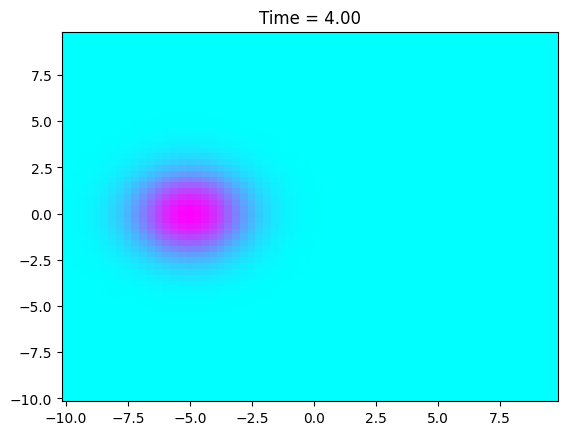

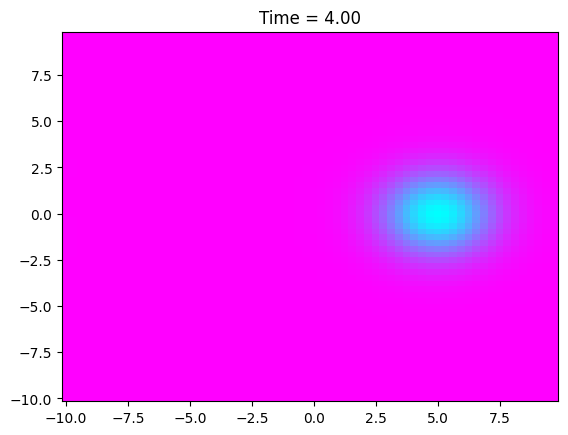

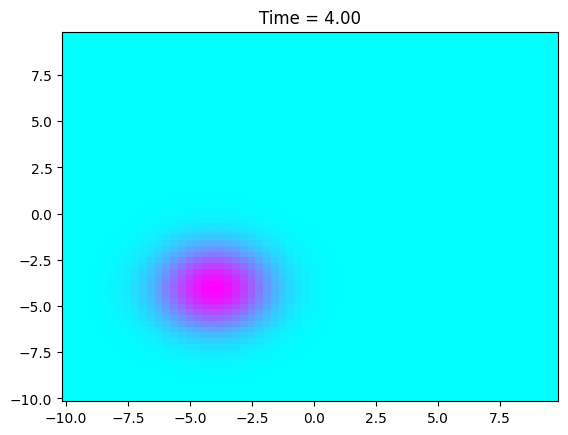

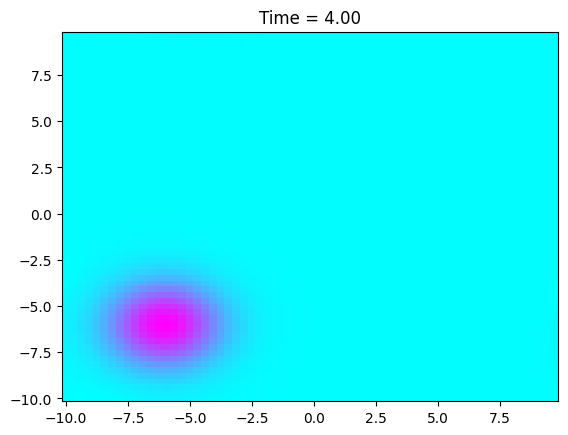

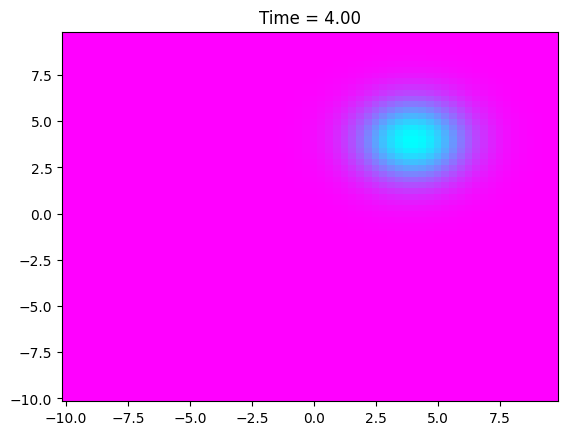

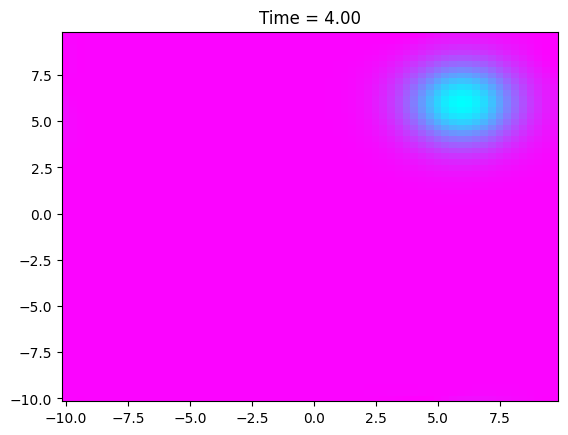

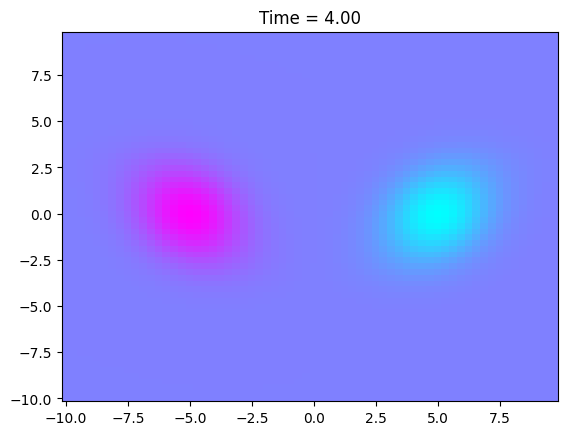

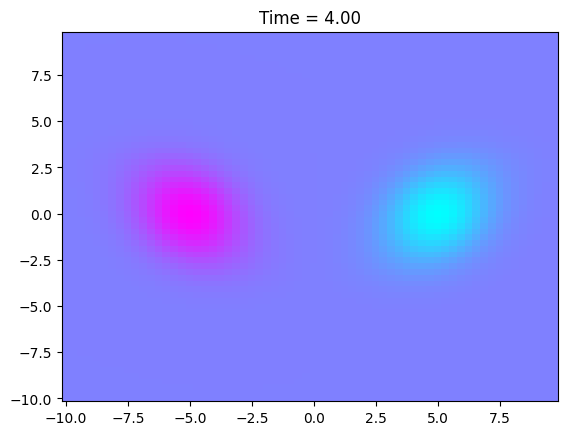

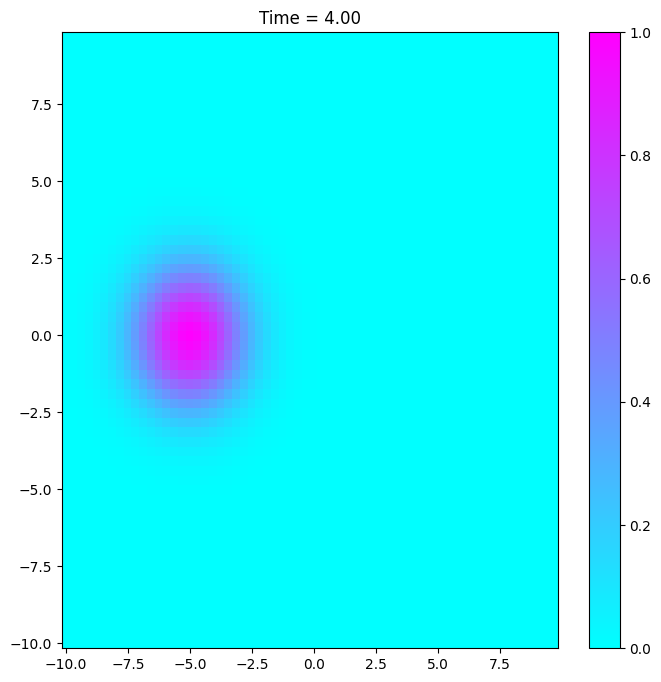

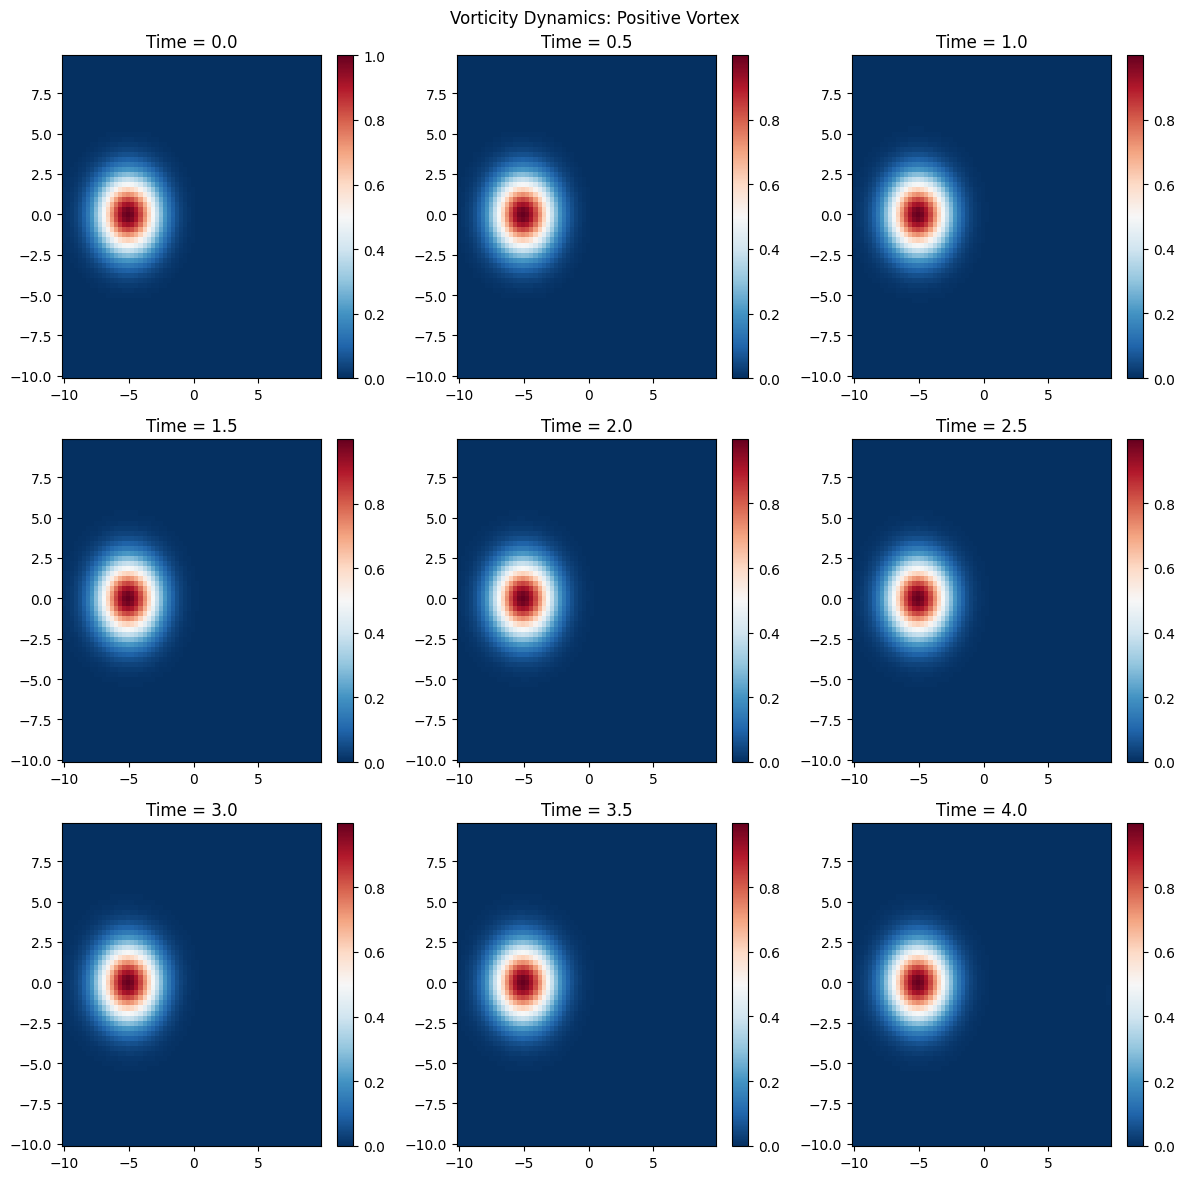

Solving for Negative Vortex...


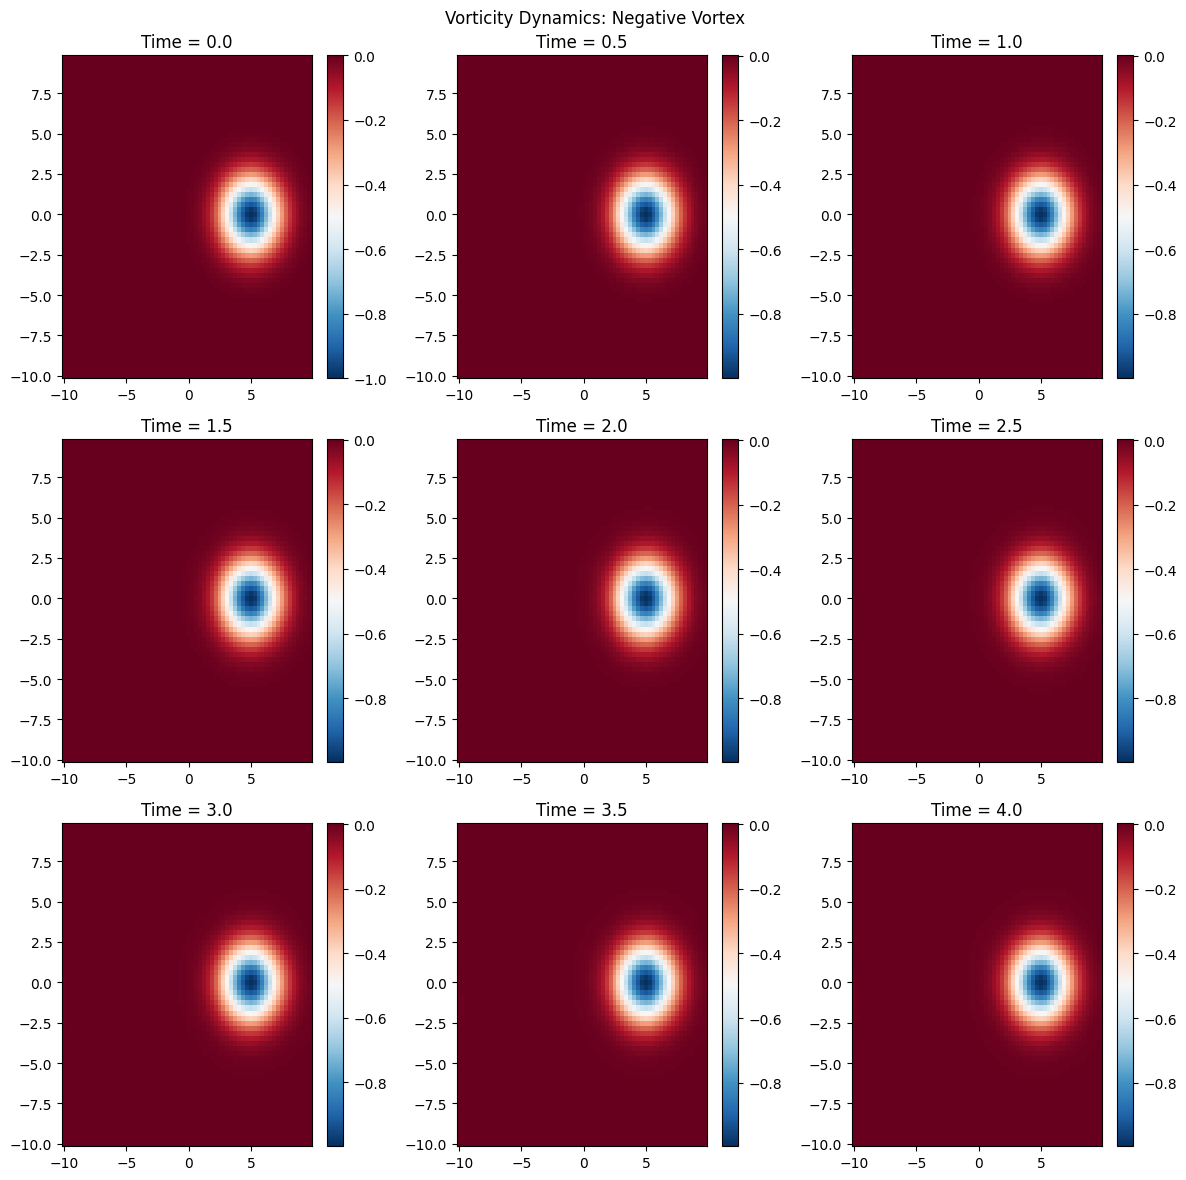

Solving for A Positive Vortex...


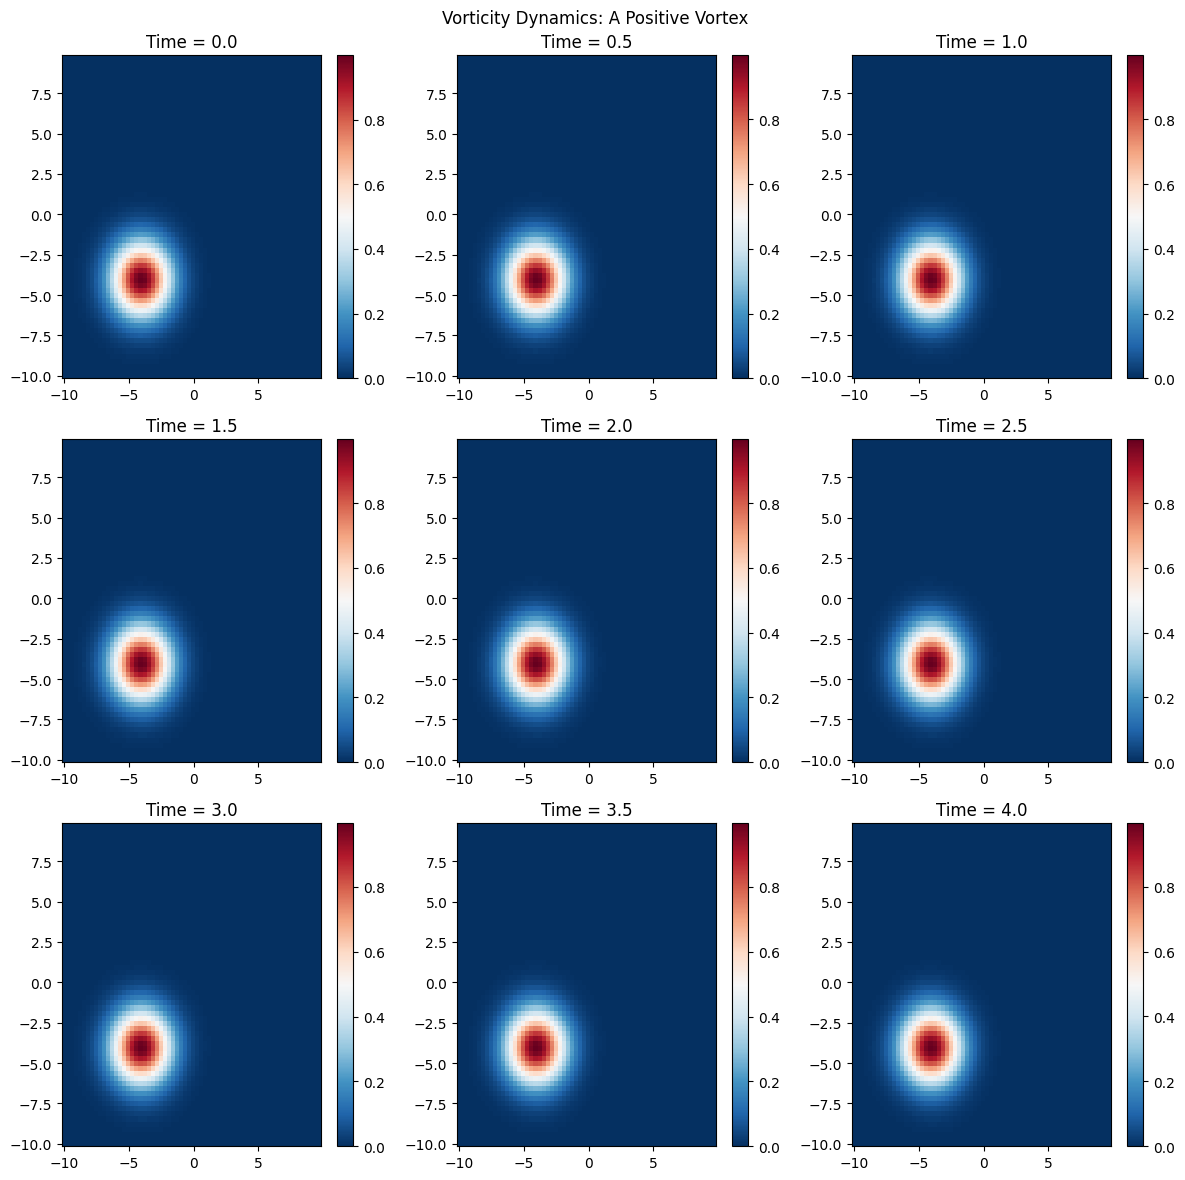

Solving for Second Positive Vortex...


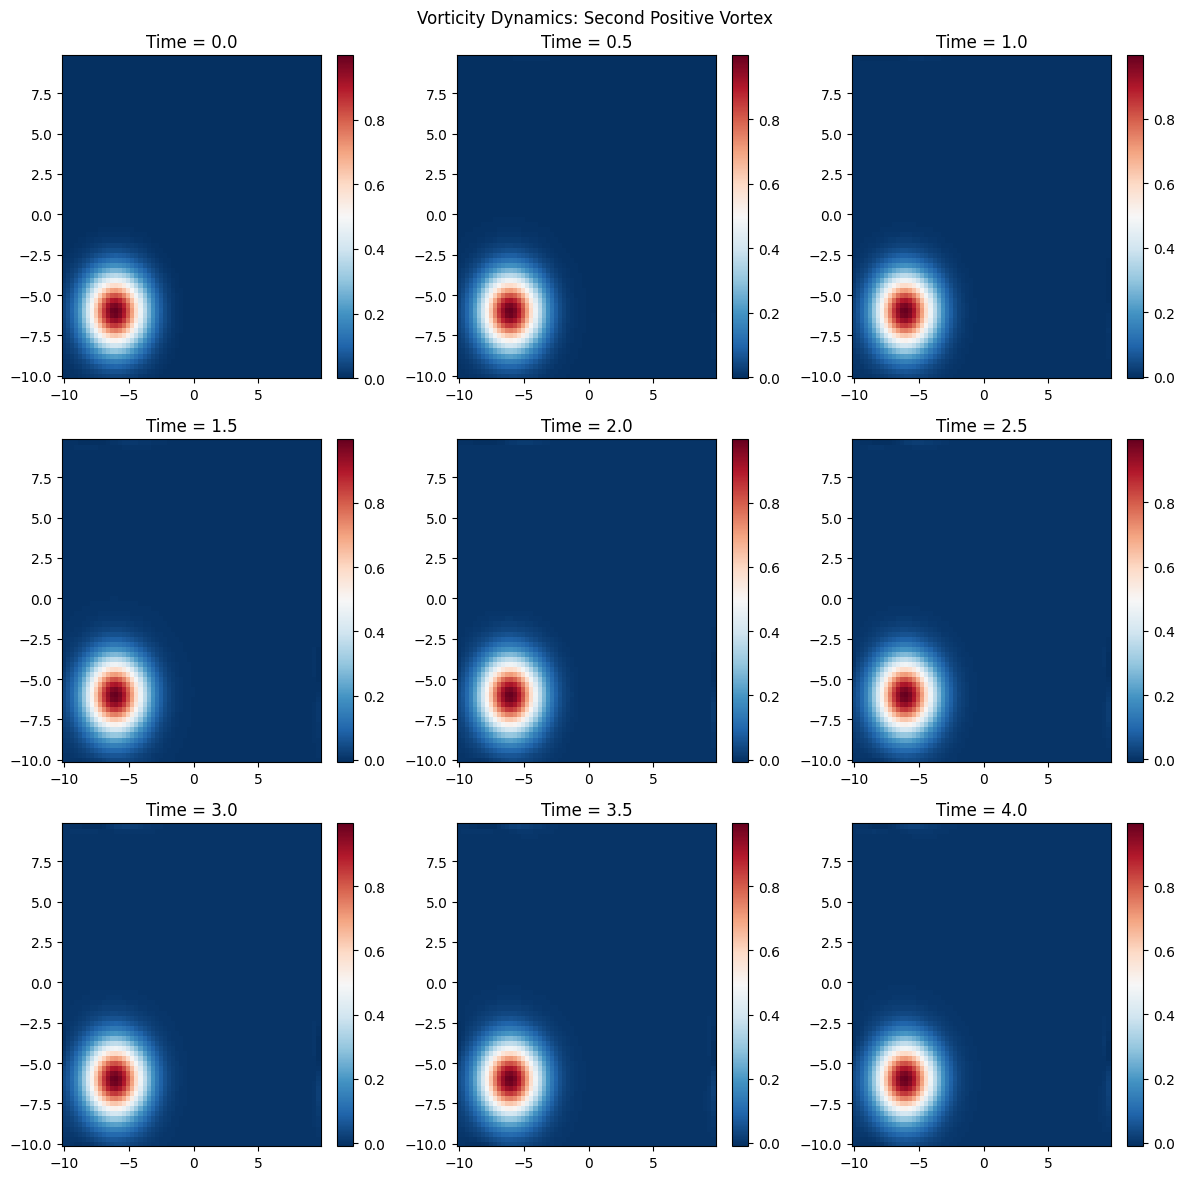

Solving for A Negative Vortex...


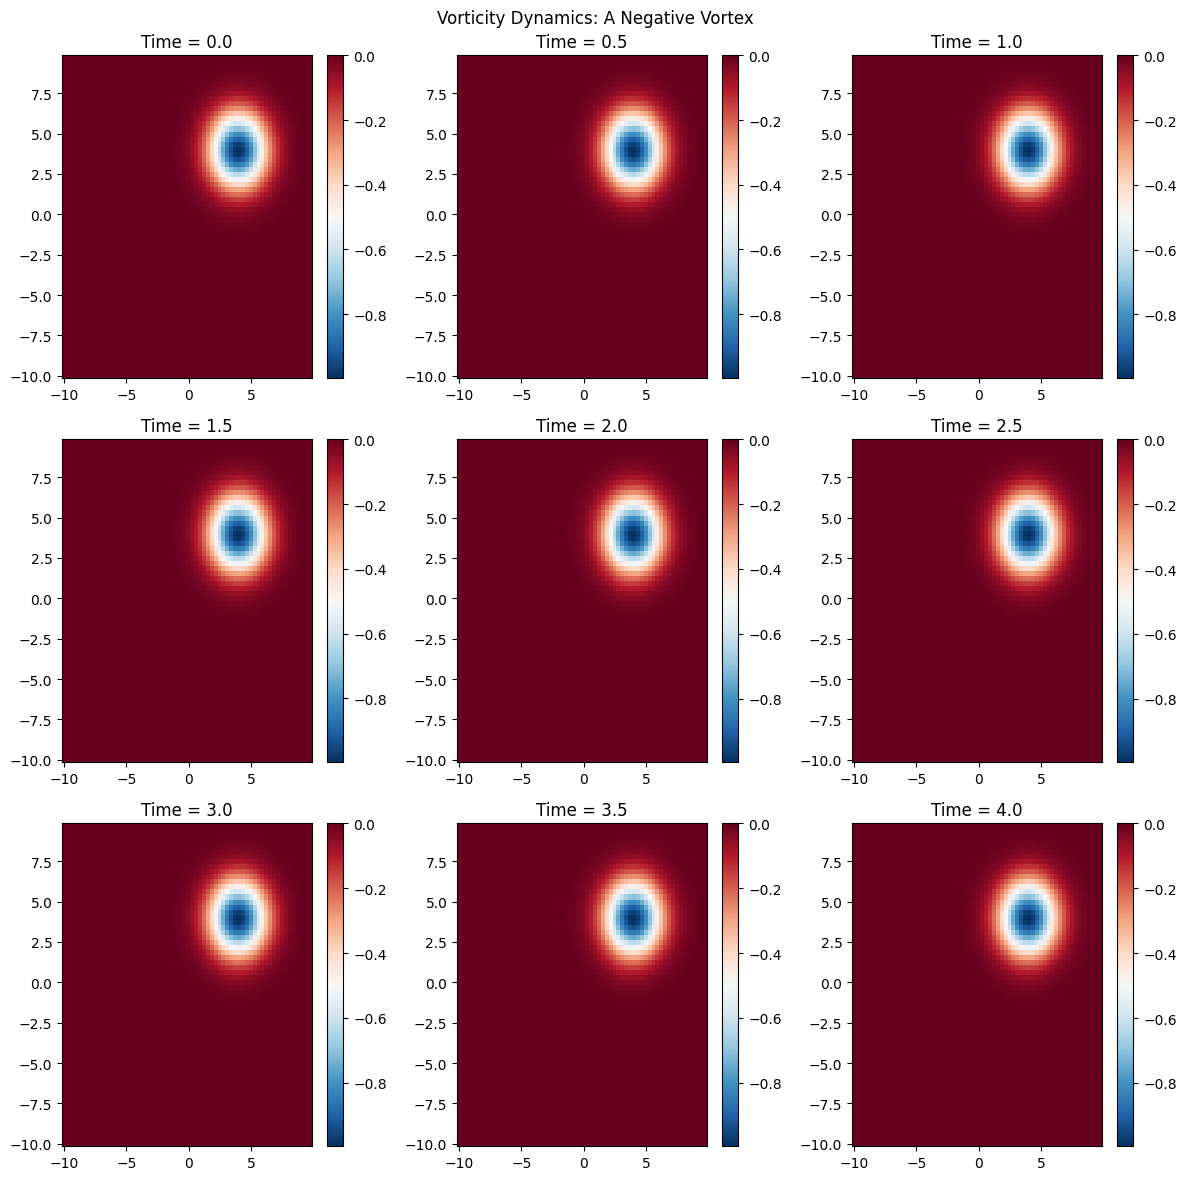

Solving for Second Negative Vortex...


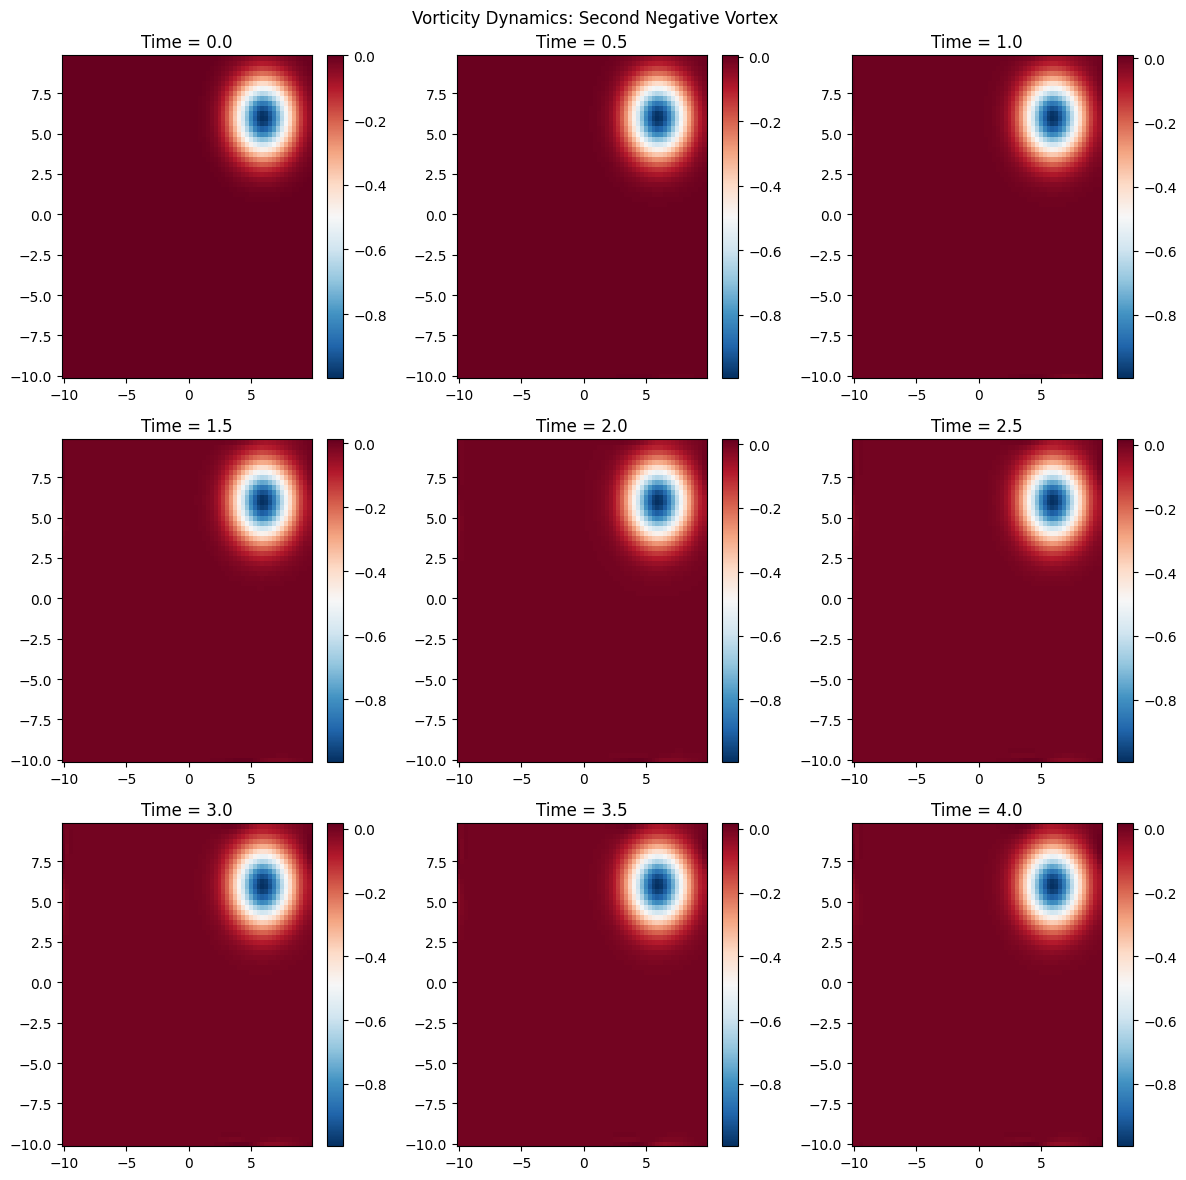

Solving for Positive and Negative Vortex Pair...


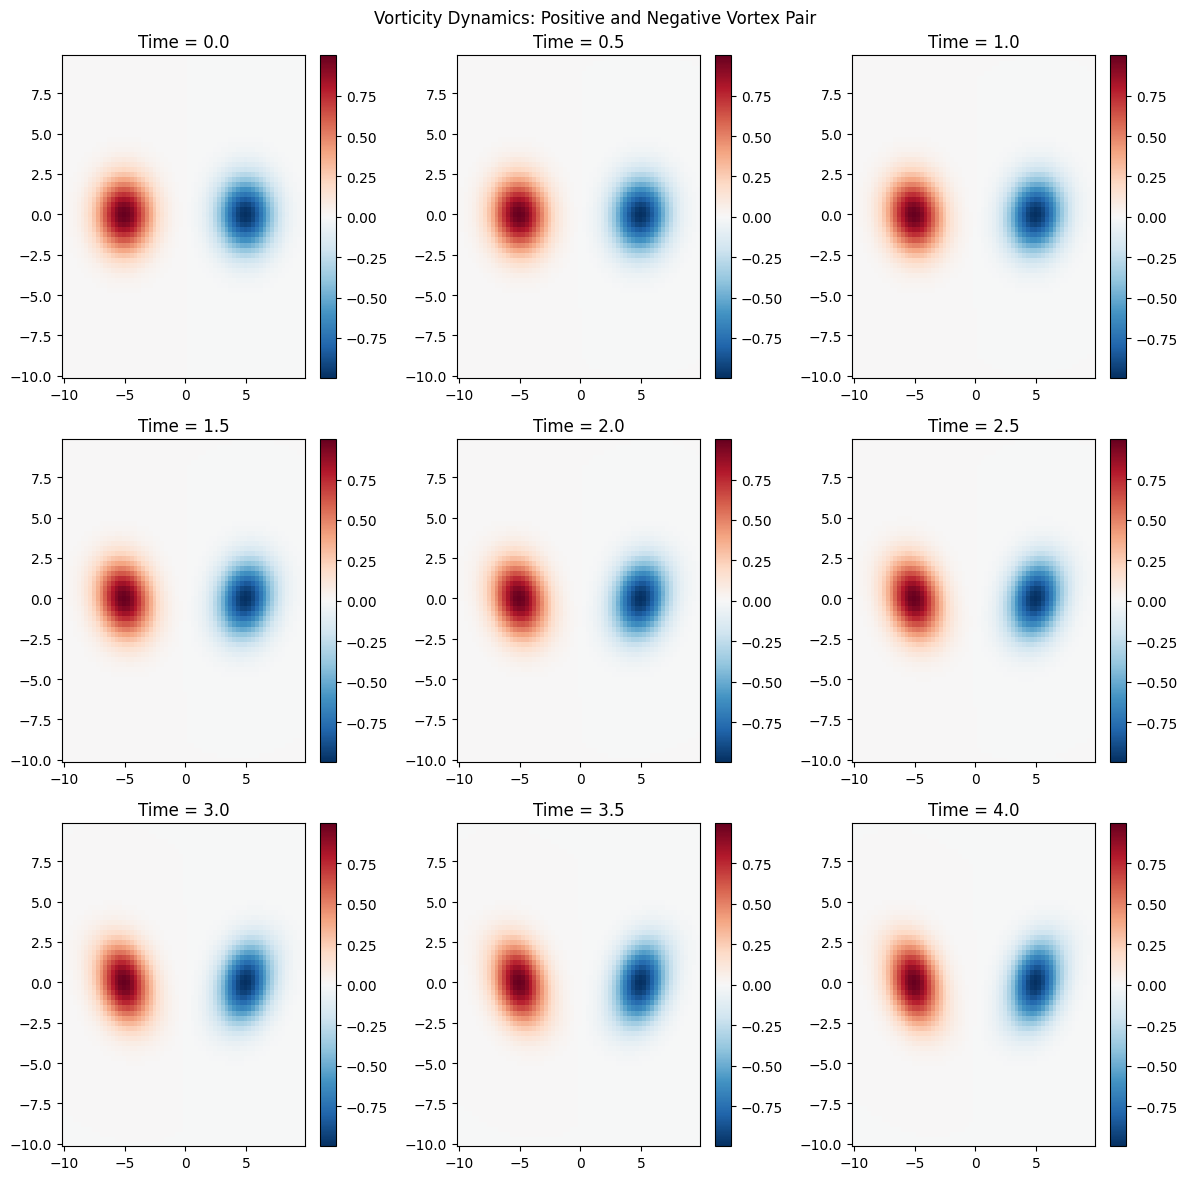

Solving for Positive at x and Negative at -x...


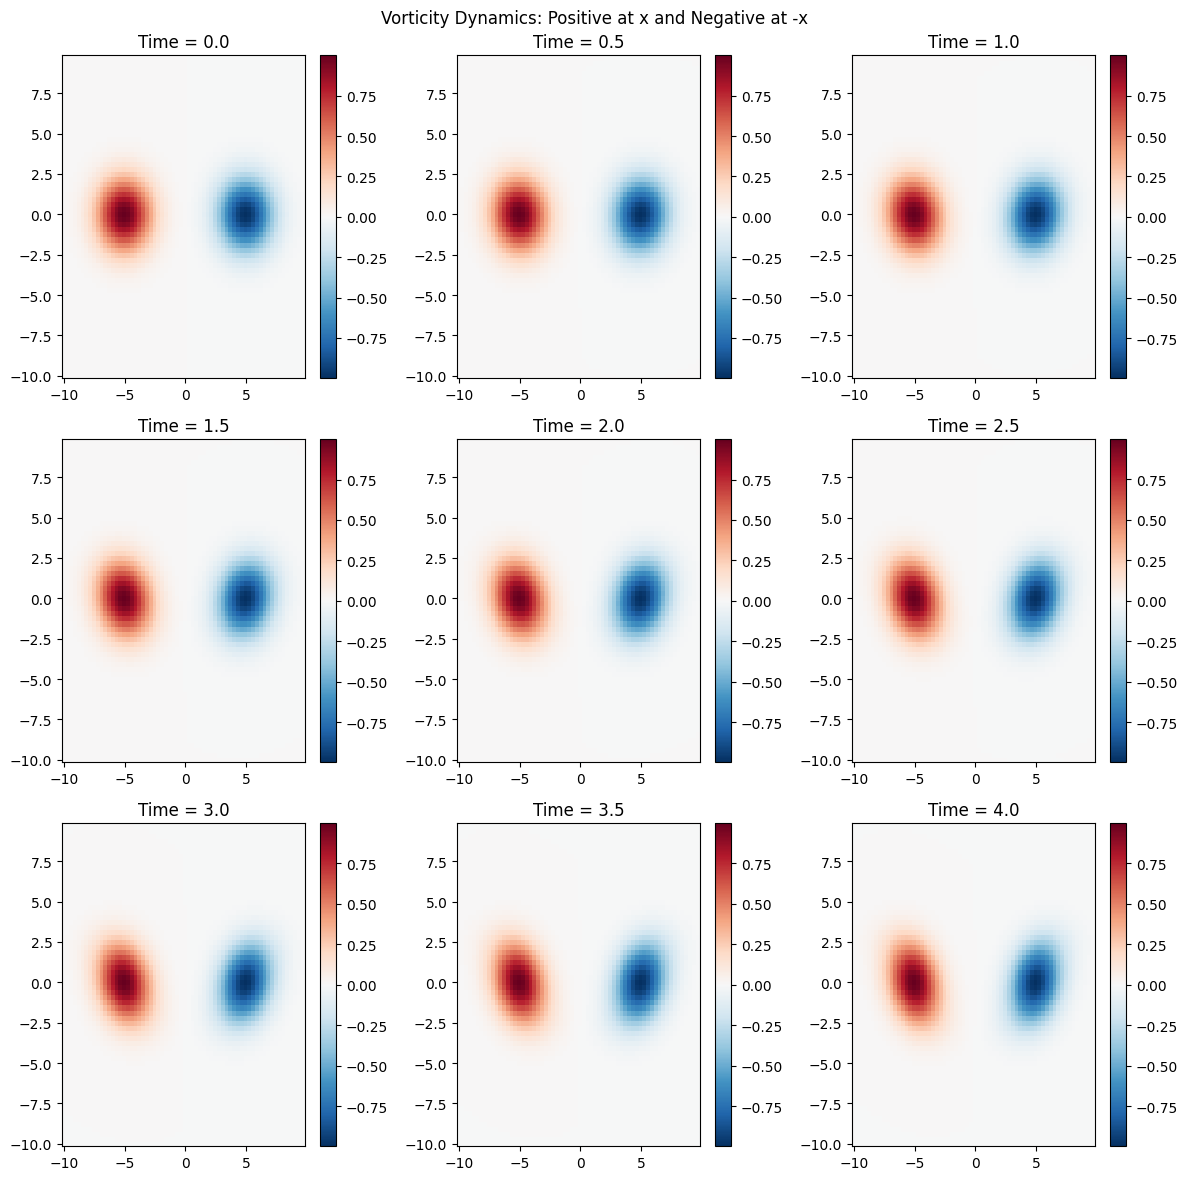

In [17]:
#Part C
# Define initial conditions for each case
def initial_condition(case):
    if case == "Positive Vortex":
        return np.exp(-((X + 5)**2 + Y**2) / 5)
    elif case == "Negative Vortex":
        return -np.exp(-((X - 5)**2 + Y**2) / 5)
    elif case == "A Positive Vortex":
        return np.exp(-((X + 4)**2 + (Y + 4)**2) / 5)
    elif case == "Second Positive Vortex":
        return np.exp(-((X + 6)**2 + (Y + 6)**2) / 5)
    elif case == "A Negative Vortex":
        return -np.exp(-((X - 4)**2 + (Y - 4)**2) / 5)
    elif case == "Second Negative Vortex":
        return -np.exp(-((X - 6)**2 + (Y - 6)**2) / 5)
    elif case == "Positive and Negative Vortex Pair":
        return np.exp(-((X + 5)**2 + Y**2) / 5) - np.exp(-((X - 5)**2 + Y**2) / 5)
    elif case == "Positive at x and Negative at -x":
        return np.exp(-((X + 5)**2 + Y**2) / 5) - np.exp(-((X - 5)**2 + (Y - 0)**2) / 5)
    else:
        raise ValueError("Unknown case.")

# Cases to solve
cases = [
    "Positive Vortex",
    "Negative Vortex",
    "A Positive Vortex",
    "Second Positive Vortex",
    "A Negative Vortex",
    "Second Negative Vortex",
    "Positive and Negative Vortex Pair",
    "Positive at x and Negative at -x"
]

# Solve for each case using your `A1` code
solutions = {}  # Store solutions for Part (d)
for case in cases:
    print(f"Solving for {case}...")
    # Set initial condition
    w_init = initial_condition(case)
    w2 = w_init.reshape(N)

    # Solve the system
    wsol = solve_ivp(
        spc_rhs, [0, 4], w2, t_eval=tspan,
        args=(nx, ny, N, KX, KY, K, nu), method='RK45'
    )
    solutions[case] = wsol.y  # Store the solution for animation

    # Visualization for Part (c)
    A1 = wsol.y  # Use the existing A1 structure
    plt.figure(figsize=(12, 12))
    for j, t in enumerate(tspan):
        w = A1[:, j].reshape((nx, ny))
        plt.subplot(3, 3, j + 1)
        plt.pcolor(x, y, np.real(w), cmap='RdBu_r', shading='auto')
        plt.title(f'Time = {t}')
        plt.colorbar()
    plt.suptitle(f"Vorticity Dynamics: {case}")
    plt.tight_layout()
    plt.show()


Solving for Positive Vortex...


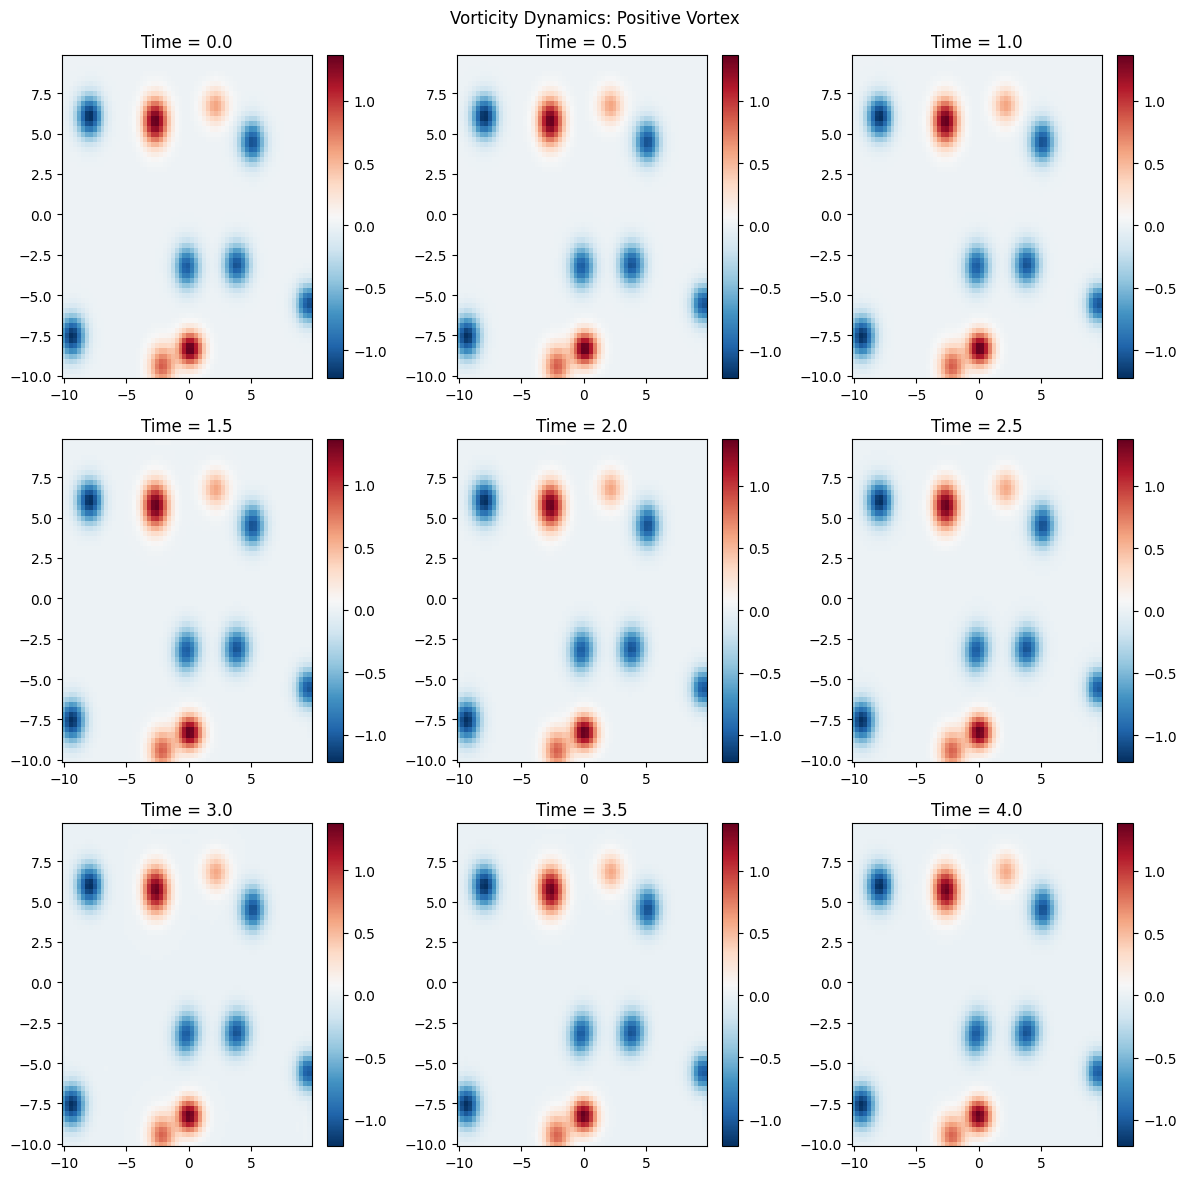

Solving for Negative Vortex...


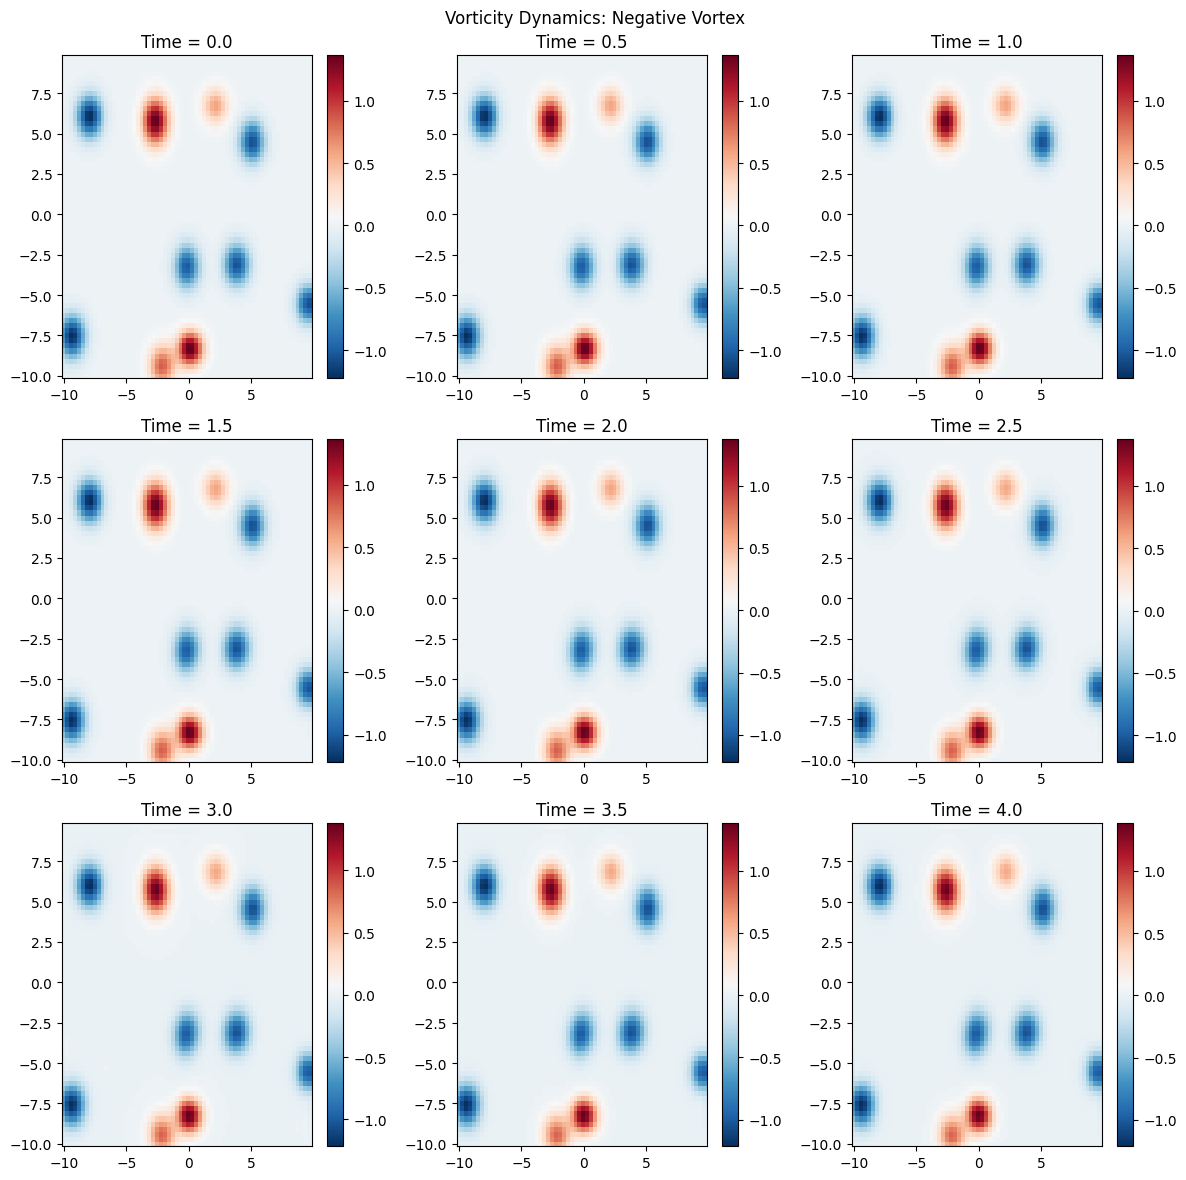

Solving for A Positive Vortex...


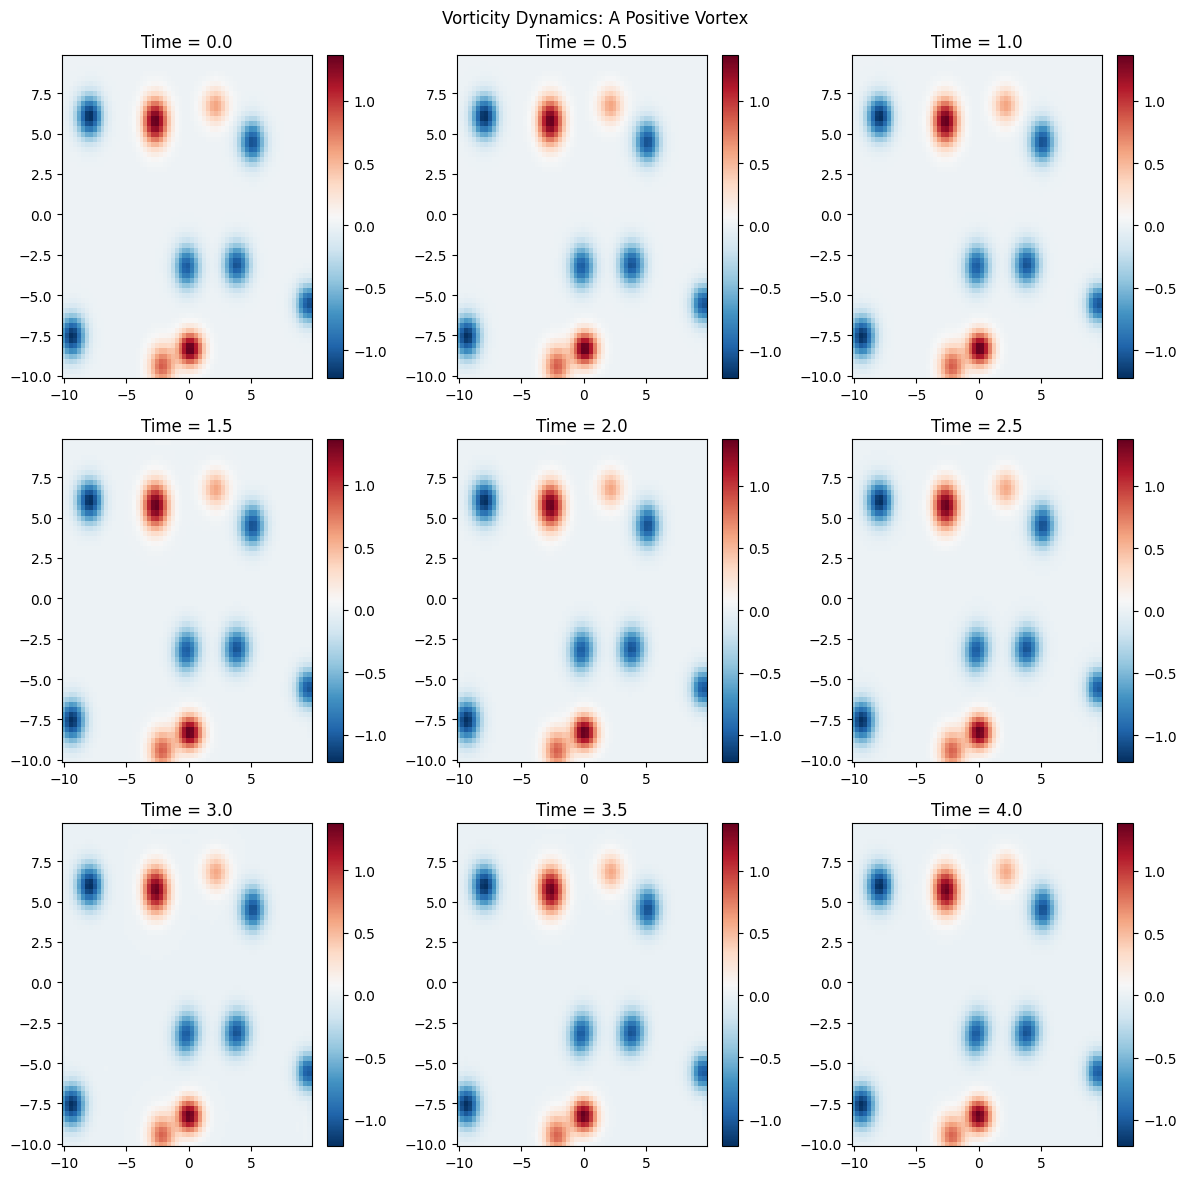

Solving for Second Positive Vortex...


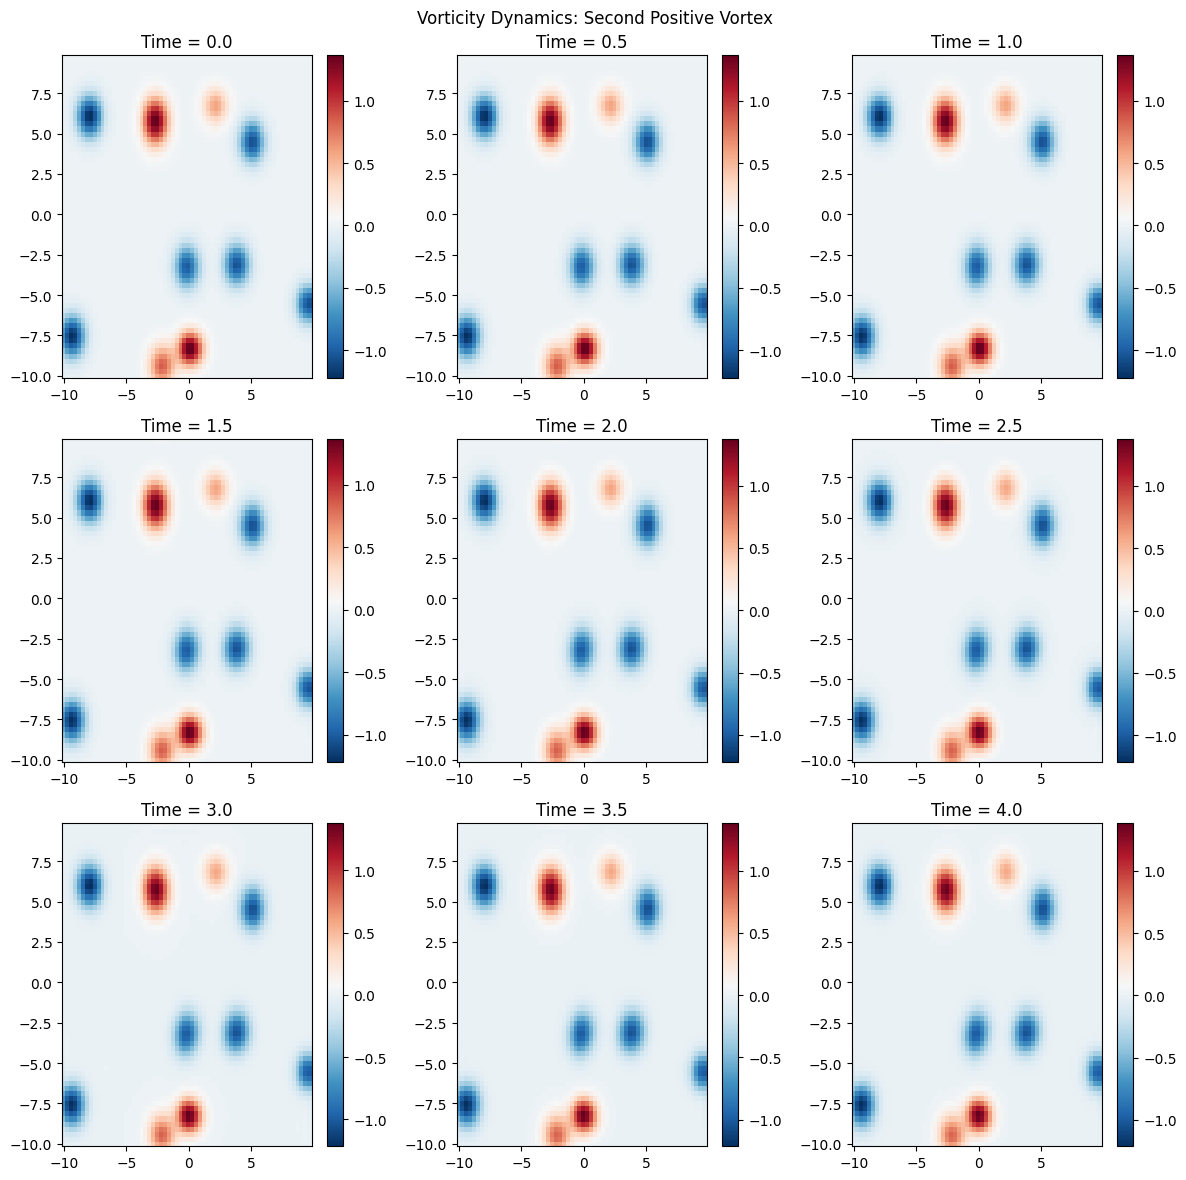

Solving for A Negative Vortex...


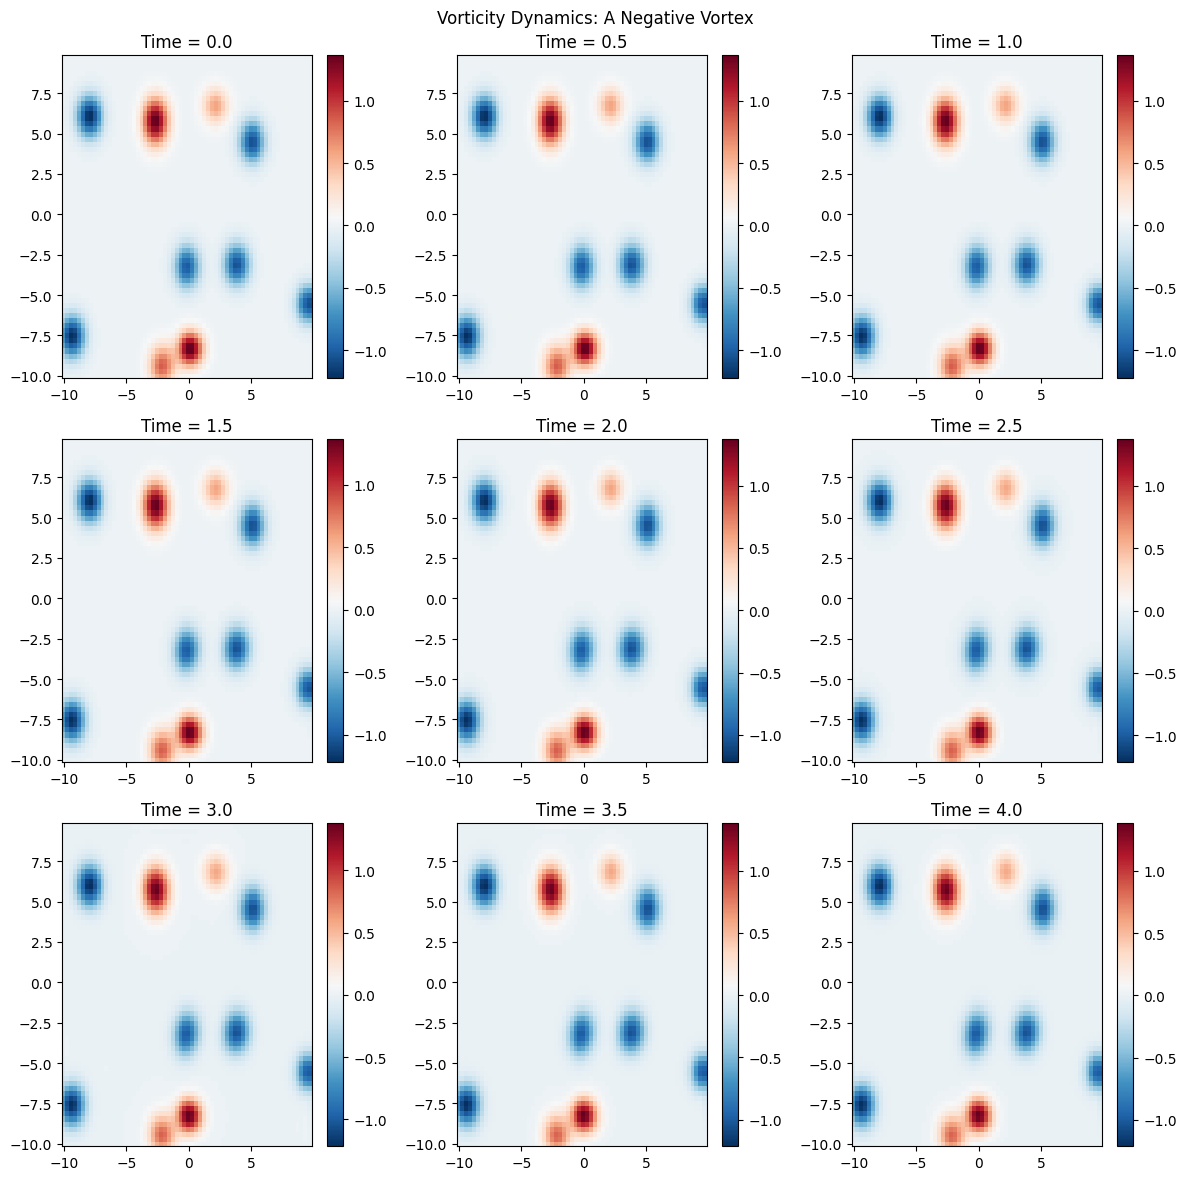

Solving for Second Negative Vortex...


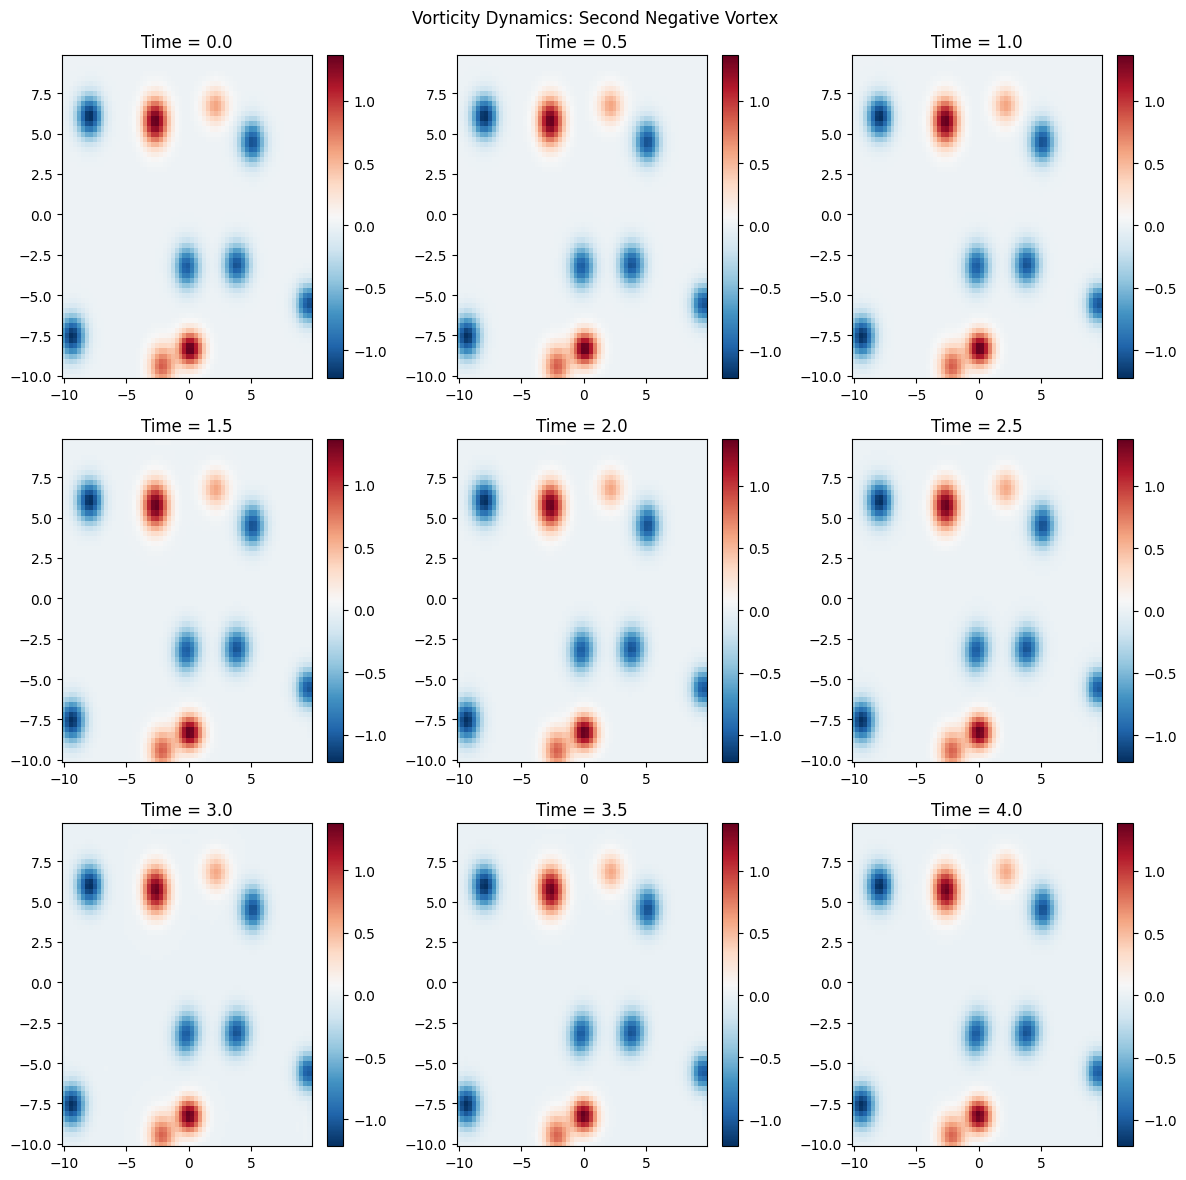

Solving for Positive and Negative Vortex Pair...


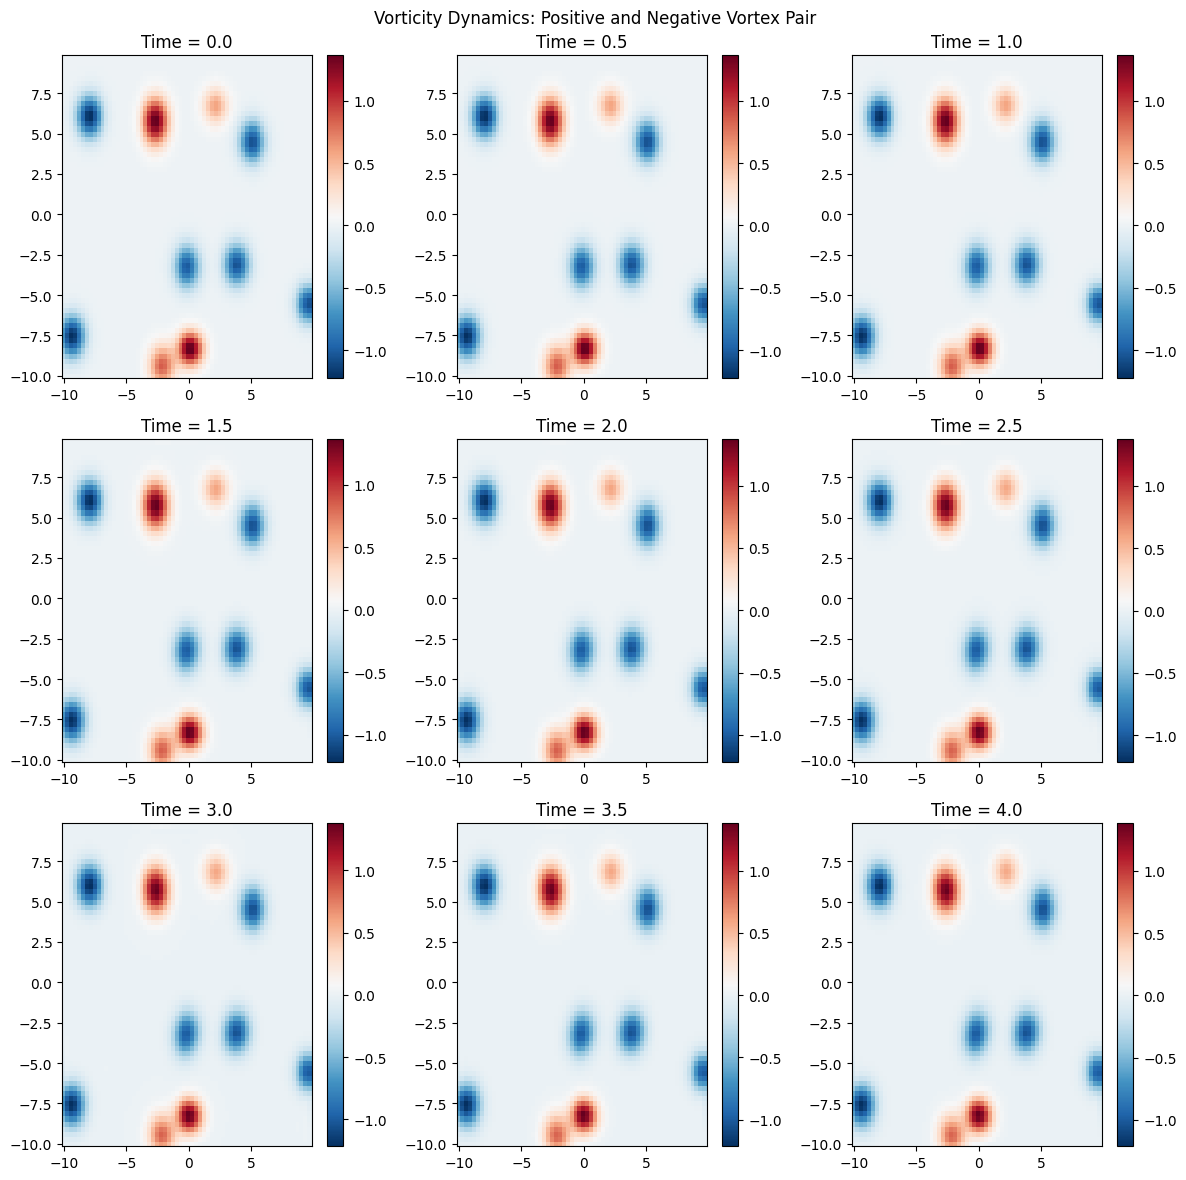

Solving for Positive at x and Negative at -x...


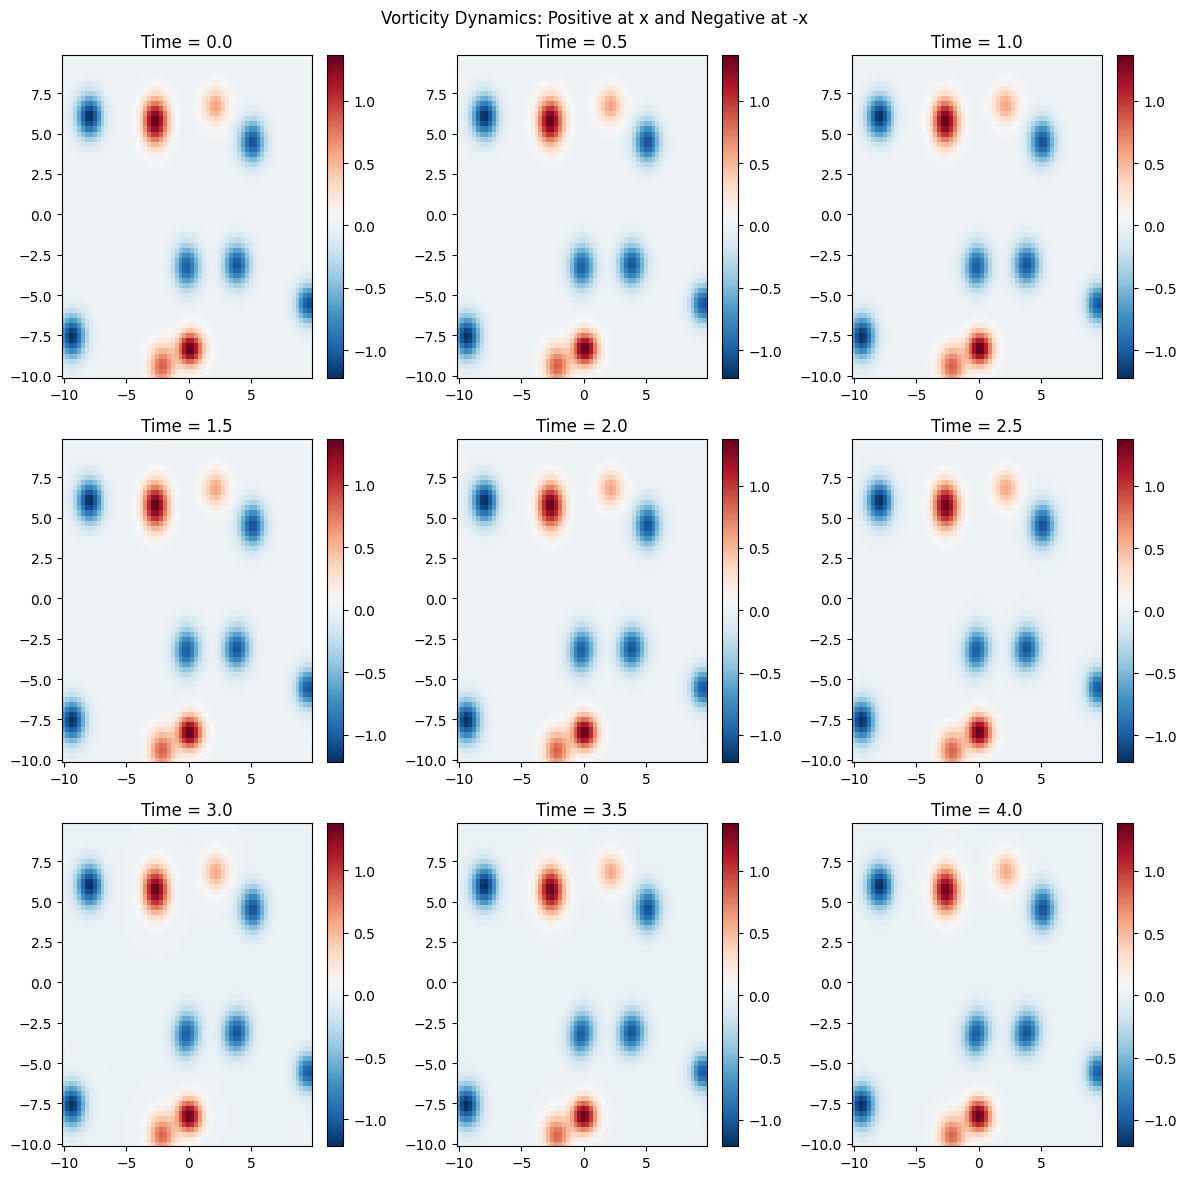


(c) Try out these initial conditions with your favorite/fastest solver on the streamfunction equations. \\
• Two oppositely “charged” Gaussian vorticies next to each other, i.e. one with positive amplitude, the other with negative amplitude. \\
• Two same “charged” Gaussian vorticies next to each other. \\
• Two pairs of oppositely “charged” vorticies which can be made to collide with each other. \\
• A random assortment (in position, strength, charge, ellipticity, etc.) of vorticies on the periodic domain. Try 10-15 vorticies and watch what happens. \\
(d) Make a 2-D movie of the dynamics. Color and coolness are key here. I would very much like to see everyone’s movies and you can put these up on your github.

In [16]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML

# Function to create and display animations
def create_animation(tspan, sol, save=False, name='animation.mp4'):
    fig, ax = plt.subplots(figsize=(8, 8))
    cmap = plt.cm.cool

    # Initialize the plot
    im = ax.pcolor(X, Y, sol[:, 0].reshape((nx, ny)), cmap=cmap, shading='auto')
    ax.set_title(f"Time = {tspan[0]:.2f}")
    plt.colorbar(im, ax=ax)

    # Update function for the animation
    def update(i):
        im.set_array(sol[:, i].reshape((nx, ny)).ravel())
        ax.set_title(f"Time = {tspan[i]:.2f}")
        return [im]

    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(tspan), interval=200, blit=True)

    # Save or display the animation
    if save:
        print(f"Saving animation to {name}...")
        writer = FFMpegWriter(fps=10, metadata=dict(artist='Vorticity Dynamics'), bitrate=1800)
        ani.save(name, writer=writer)
    else:
        plt.close(fig)  # Close the figure so it doesn’t display a static plot
        return ani

# Example: Display one animation inline
case_to_display = "Positive Vortex"  # Replace with desired case
ani = create_animation(tspan, solutions[case_to_display], save=False)

# Display the animation in Jupyter Notebook
HTML(ani.to_jshtml())
